# My new target: Kepler 5
A little simpler than Kepler 444

In [1]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time

%config InlineBackend.figure_format = "retina"

# Get the data

Get all Kepler data on Kepler-444 using Lightkurve. To start I get the target pixel files, then convert them to lightcurves using PLD.

In [2]:
search_results = lk.search_targetpixelfile("Kepler-5", mission="Kepler", exptime=1800)
search_results

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr008191672,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr008191672,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr008191672,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr008191672,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr008191672,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr008191672,0.0
...,...,...,...,...,...,...
11,Kepler Quarter 11,2012,Kepler,1800,kplr008191672,0.0
12,Kepler Quarter 12,2012,Kepler,1800,kplr008191672,0.0


In [3]:
tpfs = search_results.download_all()#download_dir="/epyc/ssd/users/tomwagg/lk_cache/")

In [4]:
lcs = [tpf.to_lightcurve(method="pld") for tpf in tpfs]
lcc = lk.LightCurveCollection(lightcurves=lcs)

Now let's look at the separate light curves, coloured by quarter

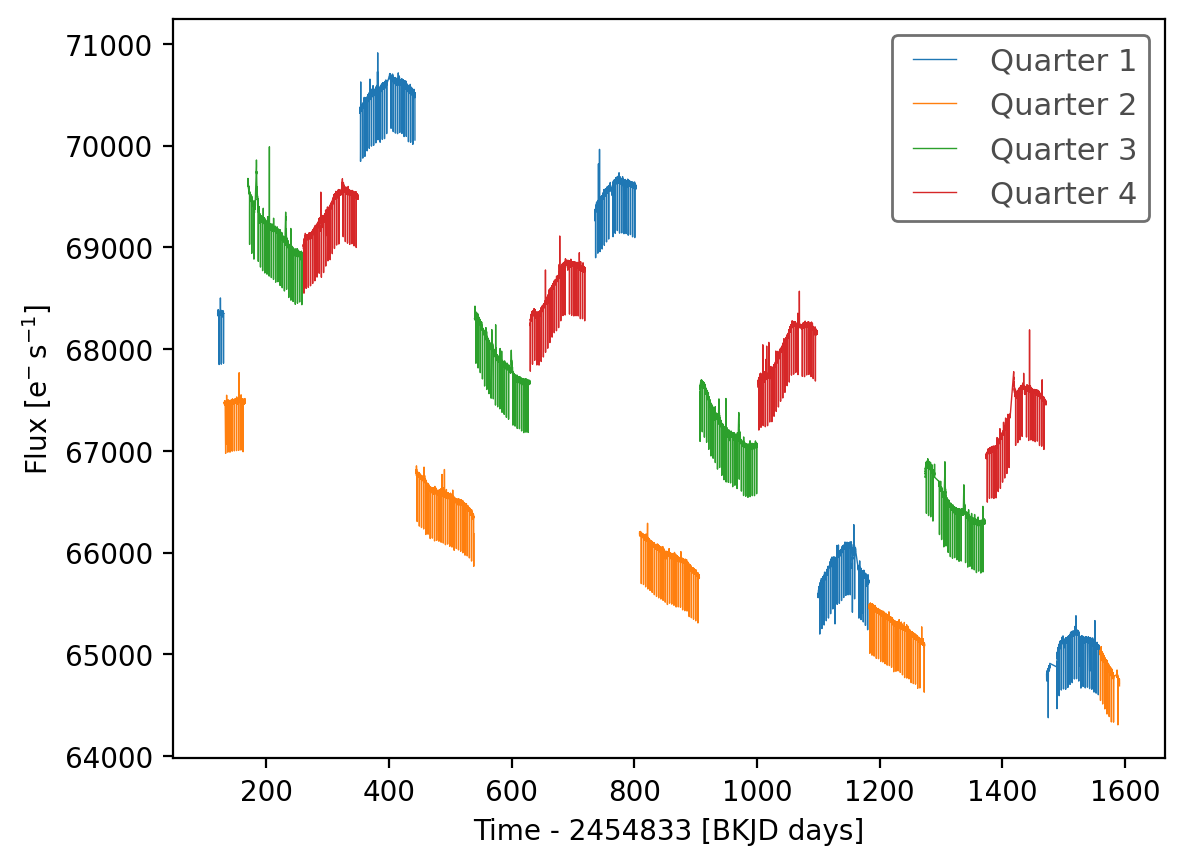

In [5]:
fig, ax = plt.subplots()
for i in range(len(lcs)):
    lcs[i].plot(ax=ax, label=f"Quarter {lcs[i].QUARTER % 4 + 1}" if i < 4 else None, color=plt.get_cmap("tab10")(lcs[i].QUARTER % 4))

Now we can use LightKurve to stitch together the lightcurves from different quarters and flatten them.

In [6]:
flat_lc = lcc.stitch().flatten()

# Remove outliers
Next we can remove outliers from the data, this is important but we have to be careful to avoid the transits.

In [7]:
_, outlier_mask = flat_lc.remove_outliers(return_mask=True)

We can see that this looks pretty good so far, but we aren't checking for transits

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

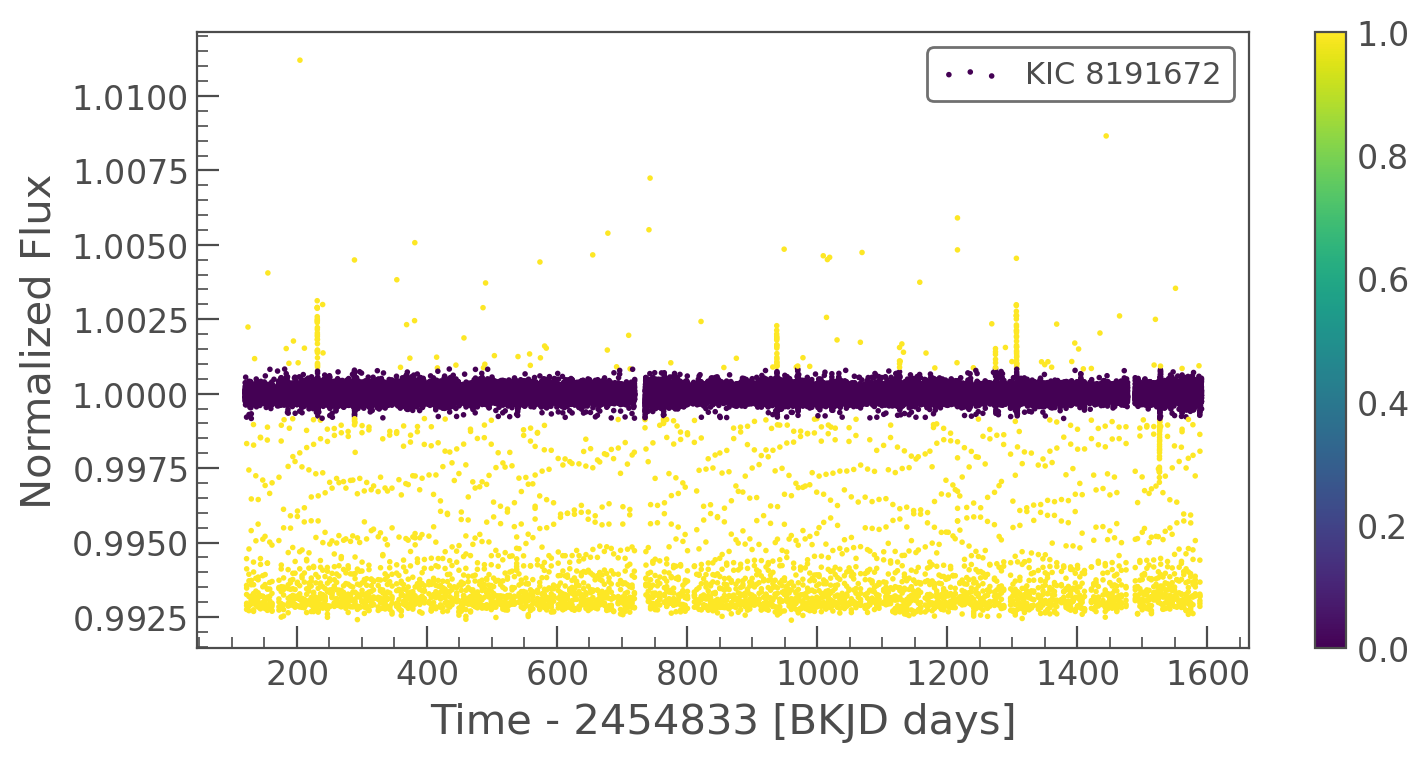

In [8]:
flat_lc.scatter(c=outlier_mask)

In [9]:
kepler_start = 2454833 * u.day
planets = ['b']
planet_parameters = {
    "b": {
        "period": 3.5484658875 * u.day,
        "t0": Time(2454955.90135000 * u.day, format="jd"),
        "radius": 0.079965,
        "t14": 4.6623  * u.hour
    },
}

In [16]:
flat_lc.time - planet_parameters["b"]["t0"]

<TimeDelta object: scale='tdb' format='jd' value=[  -2.36366112   -2.34322662   -2.32279222 ... 1468.05780602 1468.07824035
 1468.09867488]>

In [10]:
total_in_transit = np.zeros(len(flat_lc.time))
for p in "b":
    phase = (flat_lc.time - planet_parameters[p]["t0"]).to(u.day).value % planet_parameters[p]["period"].value
    # order = np.argsort(((flat_lc.time.bkjd - t0) + (p - p/2)) % p - (p - p/2))
    half_transit = 0.5 * planet_parameters[p]["t14"].to(u.day).value
    in_transit = (phase < half_transit) | (phase > planet_parameters[p]["period"].value - half_transit)
    total_in_transit += in_transit.astype(int)
any_in_transit = total_in_transit > 0

So now we use a different sigma clipping within the transits

In [11]:
_, extreme_outlier_mask = flat_lc.remove_outliers(return_mask=True, sigma=5.6, sigma_upper=1)

In [12]:
no_extreme_outliers = ~extreme_outlier_mask
no_outliers_outside_transit = ~(outlier_mask & (~any_in_transit))

In [13]:
lc = flat_lc[no_extreme_outliers & no_outliers_outside_transit]

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

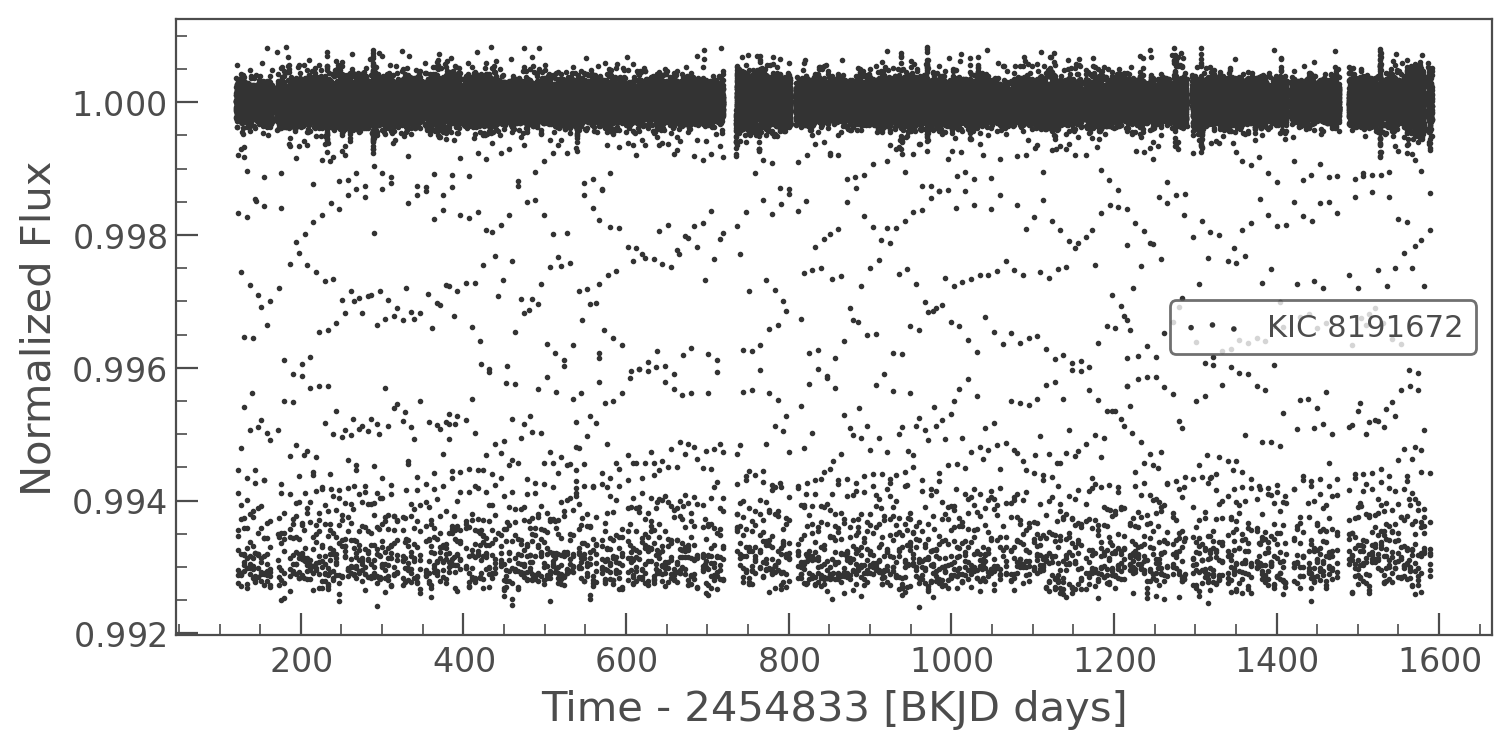

In [14]:
lc.scatter()

## Folded lightcurves

Now we can try folding the lightkurves at the different planet periods

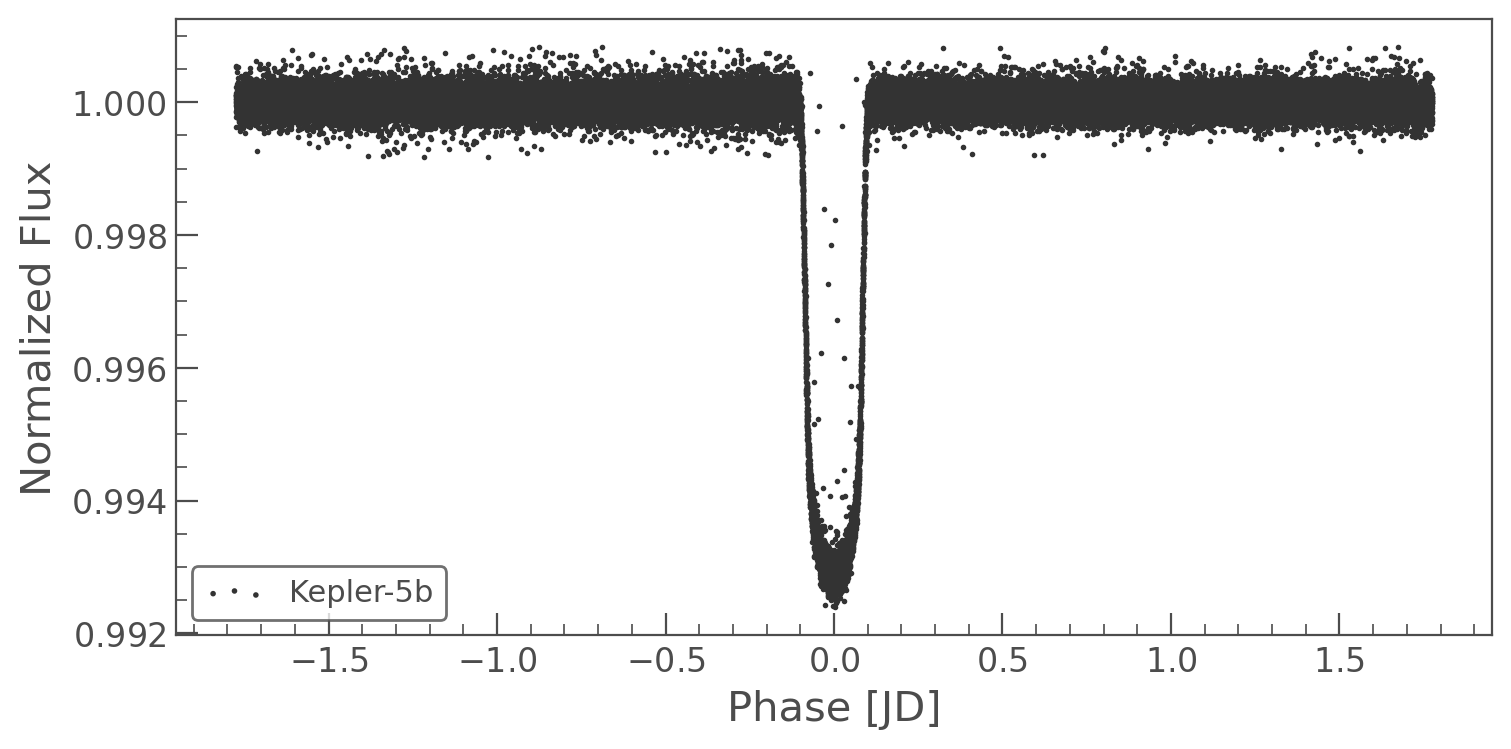

In [22]:
for planet in planets:
    ax = lc.fold(period=planet_parameters[planet]["period"],
                 epoch_time=planet_parameters[planet]["t0"].bkjd).scatter(label=f"Kepler-5{planet}")    

# Now to fit things

In [71]:
import pymc3 as pm
import pymc3_ext as pmx

periods = [planet_parameters[p]["period"].value for p in planet_parameters]
t0s = [planet_parameters[p]["t0"].bkjd for p in planet_parameters]
radii = [planet_parameters[p]["radius"] for p in planet_parameters]

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=len(t0s))

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=len(periods))
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening parameters
    limb_dark = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.001, upper=0.1, shape=len(periods), testval=radii
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=len(periods), testval=0.09680
    )

    # fix stellar density across the stars
    log_rho_star = pm.Normal("log_rho_star",
                             mu=np.log10(0.3065202), sd=1)
    rho_star = pm.Deterministic("rho_star", 10**(log_rho_star))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, rho_star=rho_star)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(limb_dark[0], limb_dark[1]).get_light_curve(
        orbit=orbit, r=r, t=lc["time"].value, texp=0.5/24
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=lc["flux_err"].value, observed=lc["flux"].value)

    # Fit for the maximum a posteriori parameters given the simulated dataset
    map_soln = pmx.optimize(start=model.test_point)

message: Desired error not necessarily achieved due to precision loss.
logp: 329320.51372446725 -> 461186.11658868333


In [54]:
planet_parameters["b"]

{'period': <Quantity 3.54846589 d>,
 't0': <Time object: scale='utc' format='jd' value=2454955.90135>,
 'radius': 0.079965,
 't14': <Quantity 4.6623 h>}

In [72]:
map_soln

{'mean': array(1.00000251),
 't0': array([122.90141495]),
 'logP': array([1.26651534]),
 'u_quadlimbdark__': array([-1.07704754, -0.54908972]),
 'r_interval__': array([1.25879728]),
 'b_impact__': array([-2.10909156]),
 'log_rho_star': array(-0.39705284),
 'period': array([3.54846578]),
 'u': array([0.36903993, 0.13500883]),
 'r': array([0.07810308]),
 'b': array([0.11666833]),
 'rho_star': array(0.40081795),
 'light_curves': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])}

In [70]:
0.306 / 0.17531024

1.7454770468627503

In [69]:
0.17531024 * 2.33

0.40847285920000004

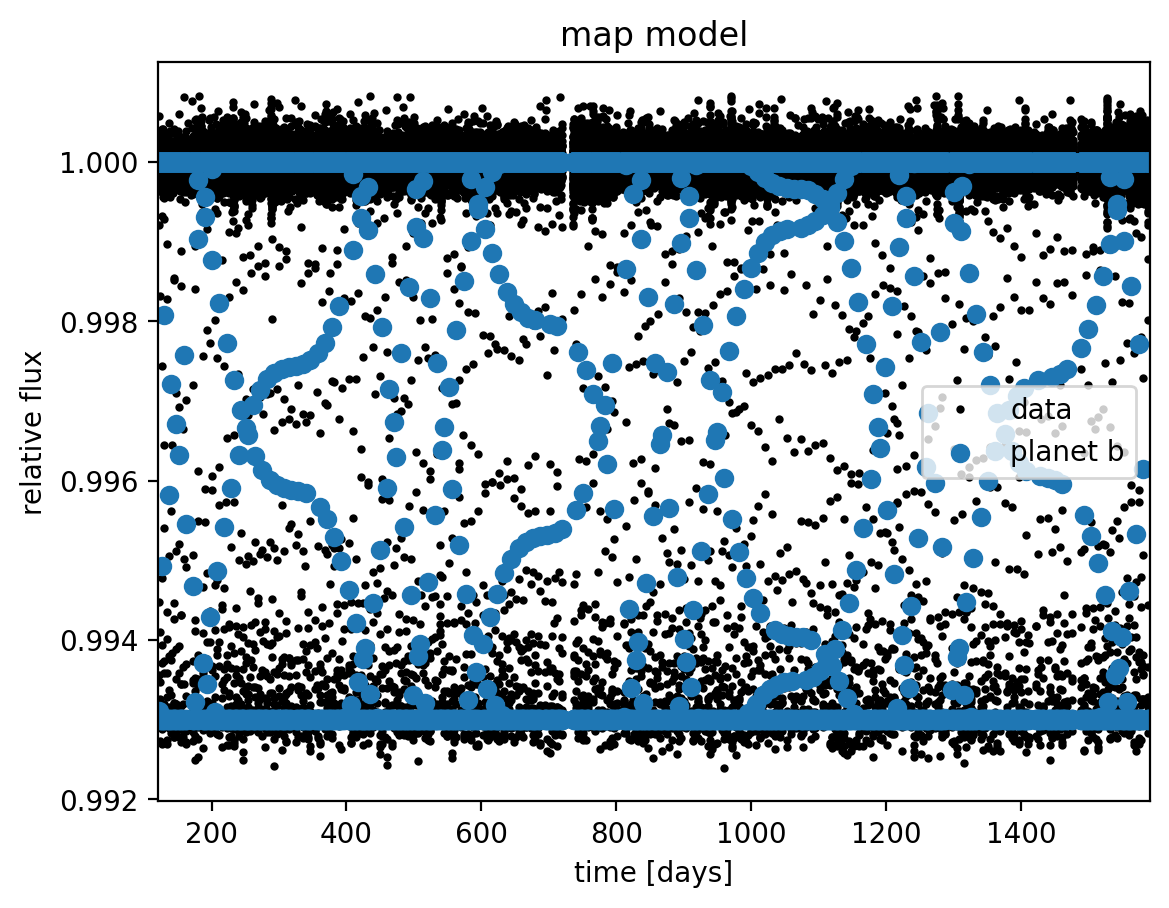

In [30]:
t, y = lc["time"].value, lc["flux"].value
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("b"):
    plt.scatter(
        t, map_soln["light_curves"][:, i] + 1, lw=1, label="planet {0}".format(l), zorder=2
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [62]:
# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=planet_parameters["b"]["period"].value, b=0.09680, rho_star=0.3065202)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.3, 0.3, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=planet_parameters["b"]["radius"], t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

(-0.3, 0.3)

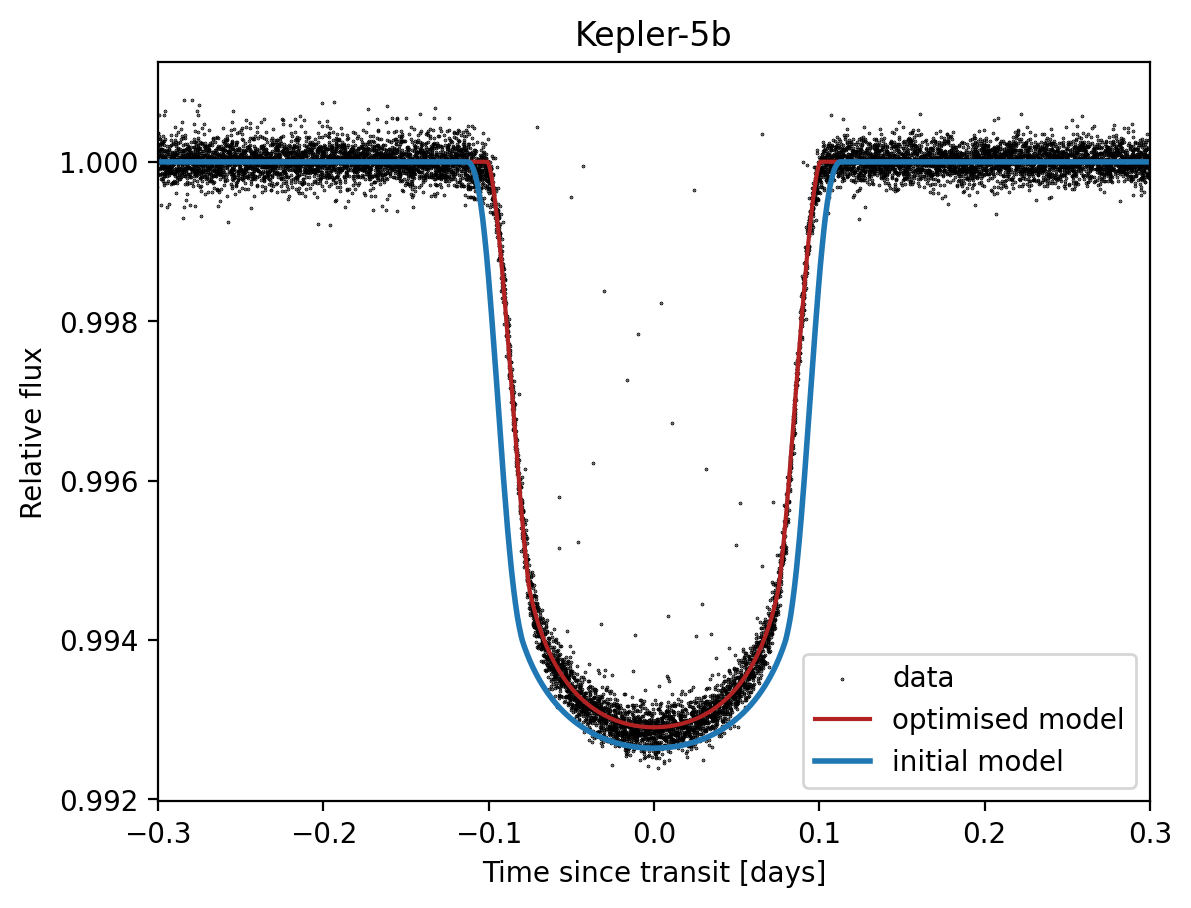

In [67]:
t = lc["time"].value

plt.figure()

p = map_soln["period"][0]
t0 = map_soln["t0"][0]

# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.scatter(
    x_fold, y, label="data", zorder=-1000, s=0.1, color="black"
)

# Plot the folded model within 0.3 days of the transit
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = map_soln["light_curves"][inds, 0] + map_soln["mean"]
plt.plot(x_fold[inds], pred, color="firebrick", label="optimised model")

t_init = np.linspace(-0.3, 0.3, 1000)
plt.plot(t_init, light_curve + 1, color="C0", lw=2, label="initial model")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("Time since transit [days]")
plt.ylabel("Relative flux")
plt.title(f"Kepler-5b")
plt.xlim(-0.3, 0.3)

In [ ]:
with model:
    trace = pmx.sample(
        tune=100,
        draws=100,
        start=map_soln,
        cores=6,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

/home/tom/miniconda3/envs/radius-valley/lib/python3.9/site-packages/pymc3_ext/sampling/schedule.py:33: UserWarning: there are not enough tuning steps to accomodate the tuning schedule; assigning automatically as 20%/70%/10%
  warnings.warn(
Only 100 samples in chain.
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [b, r, u, logP, t0, mean]
Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 225 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
trace.posterior["light_curves"]

<xarray.DataArray 'light_curves' (chain: 2, draw: 100,
                                  light_curves_dim_0: 65130,
                                  light_curves_dim_1: 1)>
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
...
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]])
Coordinates:
  * chain               (chain) int64 0 1
  * draw                (draw) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * light_curves_dim_0  (light_curves_dim_0) int64 0 1 2 3 ... 65127 65128 65129
  * light_curves_dim_1  (light_curves_dim_1) int64 0

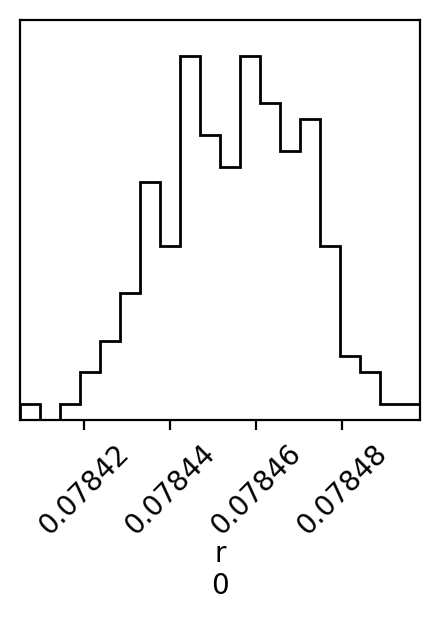

In [ ]:
import corner

truth = dict(
    zip(
        ["r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["r"],
    truths=truth,
)

In [ ]:
lcs

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [114]:
for n, letter in enumerate("b"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.scatter(
        x_fold, y - other, label="data", zorder=-1000, s=0.1, color="black"
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="firebrick", label="model")

    # Annotate the plot with the planet's period
    # txt = "period = {0:.4f} +/- {1:.4f} d".format(
    #     np.mean(period_trace), np.std(period_trace)
    # )
    # plt.annotate(
    #     txt,
    #     (0, 0),
    #     xycoords="axes fraction",
    #     xytext=(5, 5),
    #     textcoords="offset points",
    #     ha="left",
    #     va="bottom",
    #     fontsize=12,
    # )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title(f"Kepler-444{letter}")
    plt.xlim(-0.3, 0.3)

IndexError: index 1 is out of bounds for axis 3 with size 1

<Figure size 640x480 with 0 Axes>